In [1]:
from itertools import izip, cycle
import os

import mica.archive.asp_l1
from astropy.table import Table
from Quaternion import Quat
from Ska.Numpy import interpolate
from Ska.Matplotlib import plot_cxctime
import matplotlib.pyplot as plt
from Ska.engarchive import fetch_eng as fetch
from kadi import events
from mica.archive import aca_l0
from scipy.stats import scoreatpercentile
import matplotlib
from matplotlib import cm
from Chandra.Time import DateTime
from Chandra.Maneuver import attitudes, inject_errors, get_quaternions

%matplotlib inline

import Ska.arc5gl

In [2]:
solfiles = mica.archive.asp_l1.get_files(obsid=18446, revision='last', content='ASPSOL')

In [3]:
solfiles

['/data/aca/archive/asp1/18/18446_v02/pcadf588141434N002_asol1.fits.gz']

In [4]:
grnd_sol = Table.read(solfiles[-1])

In [5]:
obcfile = 'pcadf588145788N001_osol1.fits.gz'
if not os.path.exists(obcfile):
    arc5gl = Ska.arc5gl.Arc5gl()
    arc5gl.sendline('obsid=18446')
    arc5gl.sendline('version=last')
    arc5gl.sendline('get asp1{obcsol}')
    del arc5gl

In [6]:
ls

bias_stability/                   pcadf588145788N001_osol1.fits.gz
BSH_2016234_hot_pixel.ipynb       pcadf595941365N001_osol1.fits.gz
dark_current_binned.ipynb         pcadf595943989N001_osol1.fits.gz
faux_jogs/                        pcadf595945399N001_osol1.fits.gz
kalman_threshold/                 pcadf595945629N001_osol1.fits.gz
NSM_2016324_hot_pixel.ipynb       sig_bias_jogs/
pcadf588139228N001_osol1.fits.gz  useless_from_2010/


In [7]:
obc_sol = Table.read(obcfile)

In [8]:
ok = np.isclose(grnd_sol['time'], obc_sol[0]['time'], rtol=0, atol=0.01)
idx0 = np.flatnonzero(ok)[0]
grnd_sol2 = grnd_sol[idx0::4]

In [9]:
obc_sol2 = obc_sol[:len(grnd_sol2)]
assert np.allclose(obc_sol2['time'], grnd_sol2['time'])

In [10]:
# See also https://icxc.harvard.edu/mp/mplogs/2016/AUG1516/oflsa/starcheck.html#obsid18446
start = '2016:234:06:50:00'
stop = '2016:234:07:04:50'  # Start of maneuver from 18446 to 18625
R2A = np.degrees(1) * 3600

In [11]:
gb1 = fetch.Msid('aogbias1', start, stop)

In [12]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(obc_sol2['time'], drs, '-b', label='Roll')
    plot_cxctime(obc_sol2['time'], dps, '-g', label='Pitch')
    plot_cxctime(obc_sol2['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{} before manvr prior to NSM'
              .format(label))
    plt.ylabel('Change (arcsec)')
    plt.legend(loc='best');

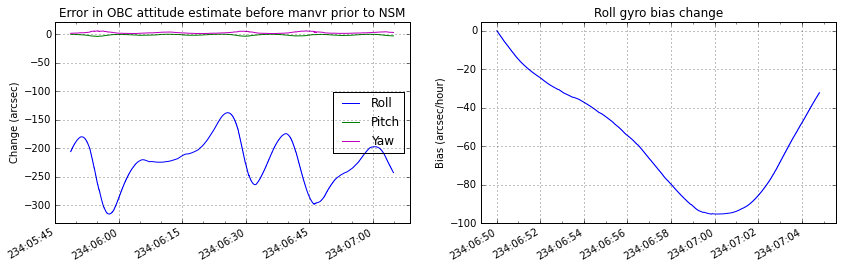

In [13]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plot_att_changes(grnd_sol2, obc_sol2, 'Error in OBC attitude estimate')

plt.subplot(1, 2, 2)
plot_cxctime(gb1.times, (gb1.vals - gb1.vals[0]) * R2A * 3600)
plt.grid()
plt.title('Roll gyro bias change')
plt.ylabel('Bias (arcsec/hour)')
plt.margins(0.05)

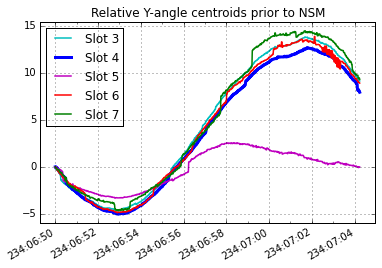

In [14]:
colors = 'cbmrg'

for slot, color in izip((3, 4, 5 ,6, 7), colors):
    lw = 3 if slot == 4 else 1.5
    yan = fetch.Msid('aoacyan{}'.format(slot), start, stop)
    yan.select_intervals(events.dwells(pad=-35))
    plot_cxctime(yan.times, yan.vals - yan.vals[0], color, 
                 label='Slot {}'.format(slot), lw=lw)
plt.margins(0.05)
plt.grid()
plt.legend(loc='best')
plt.title('Relative Y-angle centroids prior to NSM');

In [15]:
slot_data = aca_l0.get_slot_data('2016:234:06:58:00', '2016:234:07:04:30', slot=5)

In [16]:
vmax = scoreatpercentile(np.ravel(slot_data['IMGRAW']), 98)
vmin = scoreatpercentile(np.ravel(slot_data['IMGRAW']), 2)

In [17]:
DateTime(slot_data[120]['TIME']).date

'2016:234:07:02:07.383'

In [18]:
imgs = slot_data['IMGRAW'].reshape((-1, 8, 8))
imgs = imgs[:, :6, :6].filled(0)

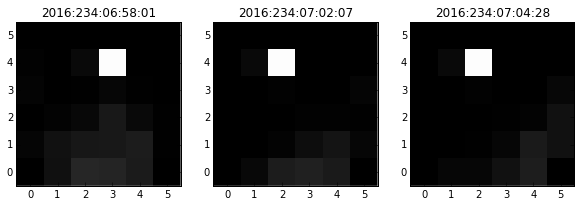

In [19]:
plt.figure(figsize=(10, 4))
for sub, idx in ((1, 0), (2, 120), (3, -1)):
    plt.subplot(1, 3, sub)
    plt.imshow(imgs[idx],
               interpolation='none',
               cmap=cm.gray,
               origin='lower',
               aspect='equal')
    plt.title(DateTime(slot_data['TIME'][idx]).date[:-4]);